#1. Introduction

This colab provides the code for Crossvalidation to asses the performance of the RoBERTa base model. This version is **stable**. The files you will need for this colab are "PETv1.1-entities.jsonl" and "complete_combined_leschneiderdata_NER.jsonl". The paths of which you need to specify.

##1.1 Preliminary Code

The code below provides the necesary libraries, paths to the input data and initial variable setups.

In [ ]:
#@title Importing and setting variables
import torch
import json
from transformers import BertTokenizer, BertForTokenClassification
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import RobertaTokenizer, RobertaForTokenClassification
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from collections import defaultdict
from sklearn.metrics import precision_recall_fscore_support
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from google.colab import files
import random
import copy

# Set a fixed seed for all random operations
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# If you're using CUDA:
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU setups
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


drive.mount('/content/drive/')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#setting up the tokenizer
#tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

#Is needed for the translation between floats and labels, as BERT's output is a float.
label_map = {
    "O": 0,
    "B-Actor": 1, "I-Actor": 2,
    "B-Activity": 3, "I-Activity": 4,
    "B-Activity Data": 5, "I-Activity Data": 6,
    "B-Further Specification": 7, "I-Further Specification": 8,
    "B-XOR Gateway": 9, "I-XOR Gateway": 10,
    "B-Condition Specification": 11, "I-Condition Specification": 12,
    "B-AND Gateway": 13, "I-AND Gateway": 14
}

short_label_map = {
    "O": 0,
    "Actor": 1,
    "Activity": 2,
    "Activity Data": 3,
    "Further Specification": 4,
    "XOR Gateway": 5,
    "Condition Specification": 6,
    "AND Gateway": 7
}

# Reverse map for evaluation purposes
reverse_label_map = {v: k for k, v in label_map.items()}
NUM_LABELS = len(label_map)  # Correctly reflects the actual classification labels


Mounted at /content/drive/


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
# Constants, can be changed for model optimisation
MAX_LEN = 128  # Or any max length suited to your data
BATCH_SIZE = 8
EPOCHS = 7

In [ ]:
#@title Printing Model Output Code
def print_token_predictions_true_labels(val_dataloader, model, tokenizer, reverse_label_map, num_samples=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()  # Ensure the model is in evaluation mode
    samples_printed = 0

    for batch in val_dataloader:
        if samples_printed >= num_samples:
            break  # Stop once we've reached the desired number of samples

        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits

        # Convert logits to predicted label IDs
        preds = torch.argmax(logits, dim=2)

        for i in range(batch['input_ids'].size(0)):
            if samples_printed >= num_samples:
                break

            input_ids = batch['input_ids'][i].cpu().numpy()
            attention_mask = batch['attention_mask'][i].cpu().numpy()
            true_label_ids = batch['labels'][i].cpu().numpy()
            pred_label_ids = preds[i].cpu().numpy()

            # Decode the input IDs to tokens
            tokens = tokenizer.convert_ids_to_tokens(input_ids, skip_special_tokens=False)

            # Skip special tokens for true and predicted labels
            true_labels = [reverse_label_map[label_id] for label_id, mask in zip(true_label_ids, attention_mask) if mask == 1]
            pred_labels = [reverse_label_map[pred_id] for pred_id, mask in zip(pred_label_ids, attention_mask) if mask == 1]

            print(f"\nSample {samples_printed + 1}:")
            print("Tokens and Labels:")
            for token, true_label, pred_label in zip(tokens, true_labels, pred_labels):
                print(f"{token}\tTrue: {true_label}\tPred: {pred_label}")
            print("\n")

            samples_printed += 1


def print_token_true_labels_per_sentence_excluding_special_tokens(val_dataloader, model, tokenizer, reverse_label_map, num_samples=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()  # Move model to the correct device and set to evaluation mode

    samples_printed = 0

    for batch in val_dataloader:
        if samples_printed >= num_samples:
            break  # Stop after reaching the desired number of samples

        batch = {k: v.to(device) for k, v in batch.items()}  # Move batch to the correct device

        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=2)

        for i in range(batch['input_ids'].size(0)):
            if samples_printed >= num_samples:
                break

            input_ids = batch['input_ids'][i].cpu().numpy()
            attention_mask = batch['attention_mask'][i].cpu().numpy()
            true_label_ids = batch['labels'][i].cpu().numpy()

            tokens = tokenizer.convert_ids_to_tokens(input_ids, skip_special_tokens=True)
            true_labels = [reverse_label_map[label_id] for label_id in true_label_ids]

            # Filter tokens and labels to exclude special tokens and corresponding labels
            filtered_tokens_and_labels = [
                (token, label) for token, label, mask in zip(tokens, true_labels, attention_mask)
                if mask == 1 and token not in tokenizer.all_special_tokens
            ]

            filtered_tokens = [token for token, _ in filtered_tokens_and_labels]
            filtered_true_labels = [label for _, label in filtered_tokens_and_labels]

            print(f"\nSample {samples_printed + 1}:")
            print("Tokens:")
            print(filtered_tokens)
            print("True Labels:")
            print(filtered_true_labels)
            print("\n")

            samples_printed += 1

# Ensure you have your val_dataloader, model, tokenizer, and reverse_label_map properly defined before calling this function.

def output_predictions_to_excel(val_dataloader, model, tokenizer, reverse_label_map, num_samples=5, file_name='output.xlsx'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()  # Ensure the model is in evaluation mode and moved to the right device
    samples_printed = 0

    # Prepare DataFrame
    columns = ['Token', 'True Label', 'Predicted Label']
    data = []

    for batch in val_dataloader:
        #if samples_printed >= num_samples:
            #break  # Stop once we've reached the desired number of samples

        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits
        preds = torch.argmax(logits, dim=2)

        for i in range(batch['input_ids'].size(0)):
            #if samples_printed >= num_samples:
                #break

            input_ids = batch['input_ids'][i].cpu().numpy()
            attention_mask = batch['attention_mask'][i].cpu().numpy()
            true_label_ids = batch['labels'][i].cpu().numpy()
            pred_label_ids = preds[i].cpu().numpy()

            tokens = tokenizer.convert_ids_to_tokens(input_ids, skip_special_tokens=False)
            true_labels = [reverse_label_map[label_id] for label_id, mask in zip(true_label_ids, attention_mask) if mask == 1]
            pred_labels = [reverse_label_map[pred_id] for pred_id, mask in zip(pred_label_ids, attention_mask) if mask == 1]

            # Append each token and its labels to the data list
            data.extend([(token, true, pred) for token, true, pred in zip(tokens, true_labels, pred_labels)])

            samples_printed += 1

    # Create DataFrame and write to Excel
    file_path = f"/content/drive/MyDrive/THESIS/CODING/BERT outputs/BERT predictions/{file_name}"
    df = pd.DataFrame(data, columns=columns)
    df.to_excel(file_path, index=False)

    print(f"Output written to {file_path}")

# Ensure your model, tokenizer, and dataloader are properly initialized before calling this function.


In [ ]:
#@title Initialization of necessary functions for crossvalidation and training of BERT

#This function is grouping and loading data per doc-id such that they are processed per doc-id. The function expects a path to a .json file
def load_and_group_ner_data(file_path):
    grouped_data = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            entry = json.loads(line)
            document_name = entry['document name']  # Adjusted to use 'document name'
            if document_name not in grouped_data:
                grouped_data[document_name] = []
            grouped_data[document_name].append(entry)
            #print(entry)
    # Sort each group by 'sentence-ID'
    for doc in grouped_data.values():
        doc.sort(key=lambda x: x['sentence-ID'])

    return list(grouped_data.values())

#For the calculation of accuracy metrics
def calculate_f1(model, dataloader, device):
    model.eval()
    true_labels, pred_labels = [], []
    with torch.no_grad():
        check_true, check_pred = set(), set()
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)



            # Flatten labels and predictions
            batch_labels = batch['labels'].detach().cpu().numpy()
            batch_predictions = predictions.detach().cpu().numpy()

            true_labels.extend(batch_labels.flatten())
            pred_labels.extend(batch_predictions.flatten())
            check_true.update(true_labels)
            check_pred.update(pred_labels)


    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted', zero_division=0)
    return precision, recall, f1


#This class tokenizes the sentences and their words according to the predefined tokenizer for BERT. Also maps the labels to their integer number values.
class NERDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len, label_map):
        self.sentences = sentences  # List of sentences (each sentence is a list of words)
        self.labels = labels        # List of label sequences corresponding to each sentence
        self.tokenizer = tokenizer  # BERT tokenizer
        self.max_len = max_len      # Maximum sequence length
        self.label_map = label_map  # Mapping from label strings to integers

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        words = self.sentences[idx]
        word_labels = self.labels[idx]

        # Tokenize words and align labels with tokens
        tokens = []
        aligned_labels = []
        for word, label in zip(words, word_labels):
            word_tokens = self.tokenizer.tokenize(word)
            tokens.extend(word_tokens)
            # Extend the label to all subwords
            aligned_labels.extend([label] * len(word_tokens))

        # Truncate tokens and labels if they exceed max_len
        tokens = tokens[:self.max_len-2]
        aligned_labels = aligned_labels[:self.max_len-2]

        # Convert tokens and labels to model inputs
        input_ids = self.tokenizer.convert_tokens_to_ids(['[CLS]'] + tokens + ['[SEP]'])
        attention_mask = [1] * len(input_ids)
        label_ids = [self.label_map['O']] + [self.label_map[label] for label in aligned_labels] + [self.label_map['O']]

        # Padding
        padding_length = self.max_len - len(input_ids)
        input_ids += [self.tokenizer.pad_token_id] * padding_length
        attention_mask += [0] * padding_length
        label_ids += [self.label_map['O']] * padding_length

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'labels': torch.tensor(label_ids, dtype=torch.long)
        }

#This function employs a BERT model training where no early stopping is used
def train_model(model, train_dataloader, val_dataloader, optimizer, scheduler, EPOCHS, label_map, checkpoint_dir='./model_checkpoints'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Directory where you want to save your model checkpoints
    os.makedirs(checkpoint_dir, exist_ok=True)

    #Initialize score
    best_f1_score = 0.0

    #In order to plot the validation and training losses to check for overfitting
    training_losses = []
    validation_losses = []

    for epoch_i in range(EPOCHS):
        print(f'Epoch {epoch_i + 1}/{EPOCHS}')
        print("Training...")
        model.train()
        total_train_loss = 0

        for step, batch in enumerate(train_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            model.zero_grad()
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            total_train_loss += loss.item()
            optimizer.step()
            scheduler.step()

            if step % 100 == 0 or step == len(train_dataloader) - 1:
                precision, recall, f1 = calculate_f1(model, val_dataloader, device)
                print(f"Step {step}, Loss: {loss.item():.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

        avg_train_loss = total_train_loss / len(train_dataloader)
        print(f'Average training loss: {avg_train_loss:.4f}\n')

        training_losses.append(avg_train_loss)

        # In each epoch we validate the current model so to get the Validation Loss for plotting.
        val_metrics = evaluate_model(model, val_dataloader, label_map)
        validation_losses.append(val_metrics['avg_val_loss'])

    return model, training_losses, validation_losses

#This function employs a BERT model training where early stopping is used
def train_model_with_early_stopping(model, train_dataloader, val_dataloader, optimizer, scheduler, EPOCHS, patience, checkpoint_dir='./model_checkpoints'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    os.makedirs(checkpoint_dir, exist_ok=True)
    best_f1_score = 0.0
    patience_counter = 0

    for epoch_i in range(EPOCHS):
        print(f'Epoch {epoch_i + 1}/{EPOCHS}')
        model.train()
        total_train_loss = 0

        for step, batch in enumerate(train_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            model.zero_grad()
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            total_train_loss += loss.item()
            optimizer.step()
            scheduler.step()

        precision, recall, f1 = calculate_f1(model, val_dataloader, device)
        print(f"Epoch {epoch_i + 1}, Validation Precision: {precision}, Recall: {recall}, F1: {f1}")

        if f1 > best_f1_score:
            best_f1_score = f1
            patience_counter = 0
            torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'best_model.pth'))
            print("Validation F1 Score improved. Saving model checkpoint.")
        else:
            patience_counter += 1
            print("Validation F1 Score did not improve.")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

        print(f'Epoch {epoch_i + 1} completed.\n')

    # Load the best model after training ends
    model.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'best_model.pth')))

def print_token_predictions_true_labels(val_dataloader, model, tokenizer, reverse_label_map, num_samples=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()  # Ensure the model is in evaluation mode
    samples_printed = 0

    for batch in val_dataloader:
        if samples_printed >= num_samples:
            break  # Stop once we've reached the desired number of samples

        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits

        # Convert logits to predicted label IDs
        preds = torch.argmax(logits, dim=2)

        for i in range(batch['input_ids'].size(0)):
            if samples_printed >= num_samples:
                break

            input_ids = batch['input_ids'][i].cpu().numpy()
            attention_mask = batch['attention_mask'][i].cpu().numpy()
            true_label_ids = batch['labels'][i].cpu().numpy()
            pred_label_ids = preds[i].cpu().numpy()

            # Decode the input IDs to tokens
            tokens = tokenizer.convert_ids_to_tokens(input_ids, skip_special_tokens=False)

            # Skip special tokens for true and predicted labels
            true_labels = [reverse_label_map[label_id] for label_id, mask in zip(true_label_ids, attention_mask) if mask == 1]
            pred_labels = [reverse_label_map[pred_id] for pred_id, mask in zip(pred_label_ids, attention_mask) if mask == 1]

            print(f"\nSample {samples_printed + 1}:")
            print("Tokens and Labels:")
            for token, true_label, pred_label in zip(tokens, true_labels, pred_labels):
                print(f"{token}\tTrue: {true_label}\tPred: {pred_label}")
            print("\n")

            samples_printed += 1


In [ ]:
#@title convert_IOB2_to_chunks
def convert_IOB2_to_chunks(nested_label_list, reverse_label_map):

    all_chunks = []
    #print(nested_label_list)
    for sentence in nested_label_list:
        #print(sentence)
        chunks = []
        current_chunk = []
        current_type = None

        for idx, label_idx in enumerate(sentence):
            label = reverse_label_map[label_idx]

            if label.startswith('B-'):
                if current_chunk:
                    chunks.append((current_type, current_chunk))
                    current_chunk = []
                current_type = label[2:]
                current_chunk = [idx, idx]  # Start a new chunk

            elif label.startswith('I-') and current_type == label[2:]:
                current_chunk[1] = idx  # Extend the current chunk

            elif label == 'O':
                if current_chunk:  # End current chunk before starting 'O' chunk
                    chunks.append((current_type, current_chunk))
                current_type = 'O'
                current_chunk = [idx, idx]  # Start a new 'O' chunk immediately


            else:  # For non-matching 'I-' or different entity types
                if current_chunk:
                    chunks.append((current_type, current_chunk))
                    current_chunk = []
                current_type = None

        if current_chunk:  # Add the last chunk if exists
            chunks.append((current_type, current_chunk))

        all_chunks.append(chunks)

    return all_chunks

In [ ]:
#@title Evaluation helper functions
def calculate_metrics_per_sentence_by_label(true_chunks_all_sentences, pred_chunks_all_sentences):
    # Initialize counters for true positives, false positives, and false negatives per label
    tp_dict = defaultdict(int)
    fp_dict = defaultdict(int)
    fn_dict = defaultdict(int)
    support_dict = defaultdict(int)


    labels = set(label for sentence in true_chunks_all_sentences + pred_chunks_all_sentences for label, _ in sentence)

    #For the calculation of support
    for true_chunks in true_chunks_all_sentences:
        for label, _ in true_chunks:
            support_dict[label] += 1

    #For the calculation of precision, recall and F1
    for true_chunks, pred_chunks in zip(true_chunks_all_sentences, pred_chunks_all_sentences):
        true_set = set((label, tuple(indices)) for label, indices in true_chunks)
        pred_set = set((label, tuple(indices)) for label, indices in pred_chunks)

        # True Positives per label
        for label, indices in true_set & pred_set:
            tp_dict[label] += 1

        # False Positives per label
        for label, indices in pred_set - true_set:
            fp_dict[label] += 1

        # False Negatives per label
        for label, indices in true_set - pred_set:
            fn_dict[label] += 1

    # Calculate metrics per label
    metrics_per_label = {}
    for label in labels:
        tp = tp_dict[label]
        fp = fp_dict[label]
        fn = fn_dict[label]
        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
        support = support_dict[label]

        metrics_per_label[label] = {
            "Precision": precision,
            "Recall": recall,
            "F1": f1,
            "Support": support,
            "TP": tp,
            "FP": fp,
            "FN": fn
        }

    return metrics_per_label

def calculate_macro_averaged_f1(metrics_per_label):
    f1_scores = [metrics['F1'] for metrics in metrics_per_label.values()]
    macro_averaged_f1 = sum(f1_scores) / len(f1_scores) if f1_scores else 0
    return macro_averaged_f1

def calculate_micro_f1(metrics_per_label):
    # Initialize counters for total TP, FP, and FN
    total_tp = 0
    total_fp = 0
    total_fn = 0

    # Iterate through each label in the metrics_per_label dictionary
    for label, metrics in metrics_per_label.items():
        # Extract the TP, FP, and FN for the current label
        tp = metrics["TP"]
        fp = metrics["FP"]
        fn = metrics["FN"]

        # Accumulate the total TP, FP, and FN
        total_tp += tp
        total_fp += fp
        total_fn += fn

    # Calculate micro precision and recall
    if (total_tp + total_fp) > 0:
        micro_precision = total_tp / (total_tp + total_fp)
    else:
        micro_precision = 0

    if (total_tp + total_fn) > 0:
        micro_recall = total_tp / (total_tp + total_fn)
    else:
        micro_recall = 0

    # Calculate micro F1 score
    if (micro_precision + micro_recall) > 0:
        micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)
    else:
        micro_f1 = 0

    return micro_f1

def calculate_weighted_f1(metrics_per_label):

    # Initialize variables for the sum of weighted F1 scores and the total support
    weighted_f1_sum = 0
    total_support = 0

    # Iterate through each label in the metrics_per_label dictionary
    for label, metrics in metrics_per_label.items():
        # Extract the F1 score and support for the current label
        f1_score = metrics["F1"]
        support = metrics["Support"]

        # Add the product of the current label's F1 score and its support to the sum of weighted F1 scores
        weighted_f1_sum += f1_score * support

        # Add the current label's support to the total support
        total_support += support

    # Calculate the overall weighted F1 score by dividing the sum of weighted F1 scores by the total support
    if total_support > 0:
        overall_weighted_f1 = weighted_f1_sum / total_support
    else:
        overall_weighted_f1 = 0

    return overall_weighted_f1

def convert_int_2string(nested_label_list, reverse_label_map):

    all_chunks = []

    for sentence in nested_label_list:
        chunks = []
        current_chunk = []
        current_label = None

        for idx, label_idx in enumerate(sentence):
            label = reverse_label_map[label_idx]

            if current_label is None or current_label != label:
                if current_chunk:
                    chunks.append((current_label, current_chunk))
                current_label = label
                current_chunk = [idx, idx]
            else:
                current_chunk[1] = idx

        if current_chunk:
            chunks.append((current_label, current_chunk))

        all_chunks.append(chunks)

    return all_chunks

def get_sorted_labels(val_metrics):

    pairs = []
    non_paired_labels = []

    for label in sorted(val_metrics['detailed_metrics'].keys()):  # Sort keys to maintain alphabetical order
        if label.startswith("B-"):
            corresponding_i_label = f"I-{label[2:]}"
            if corresponding_i_label in val_metrics['detailed_metrics']:
                pairs.append((label, corresponding_i_label))
            else:
                non_paired_labels.append(label)  # Add B- label if I- counterpart not found
        elif not label.startswith("I-"):  # This will automatically handle 'O' and other non B-/I- labels
            non_paired_labels.append(label)

    # Flatten the sorted pairs
    sorted_labels = [label for pair in pairs for label in pair]

    # Add non-paired labels at the end
    sorted_labels.extend(non_paired_labels)

    return sorted_labels


The next functions are used for model evaluation

In [ ]:
#@title Main Evaluation function & Plotting
def evaluate_model(model, val_dataloader, label_map):
    # Set the device to GPU if available, else CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Switch the model to evaluation mode to disable dropout layers
    model.eval()

    # Initialize variables to accumulate loss and store predictions and true labels
    eval_loss = 0
    nb_eval_steps = 0
    true_labels = []
    pred_labels = []

    # Iterate over batches in the validation dataloader
    for batch in val_dataloader:
        # Move batch data to the same device as the model
        batch = {k: v.to(device) for k, v in batch.items()}

        # Perform inference (forward pass) without computing gradients
        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits
            eval_loss += outputs.loss.item()

        # Convert logits to predicted class indices
        preds = np.argmax(logits.detach().cpu().numpy(), axis=2)

        # Collect true and predicted labels for each sentence in the batch
        for i in range(batch["input_ids"].shape[0]):
            # Use attention mask to filter out padding tokens
            mask = batch["attention_mask"][i].cpu().numpy()
            true_sequence = batch["labels"][i].cpu().numpy()[mask == 1]
            pred_sequence = preds[i][mask == 1]

            # Append individual sentence-level lists
            true_labels.append(true_sequence.tolist())  # Convert to list for consistency
            pred_labels.append(pred_sequence.tolist())

        nb_eval_steps += 1

    #Then passed it through a function that converts the predictions into entities and at the same time from a integer to a string. We do this for the True and Predicted labels altogether
    #We get something like ['Actor', [1, 3]]
    #true_labels_entities = convert_IOB2_to_chunks(true_labels, reverse_label_map)
    #pred_labels_entities = convert_IOB2_to_chunks(pred_labels, reverse_label_map)

    true_labels_entities = convert_int_2string(true_labels, reverse_label_map)
    pred_labels_entities = convert_int_2string(pred_labels, reverse_label_map)
    print(f"True labels {true_labels_entities}")
    print(f"Pred labels {pred_labels_entities}")


    #We calculate metrics per label
    #label_metrics = compare_entities(true_labels_entities, pred_labels_entities)
    label_metrics = calculate_metrics_per_sentence_by_label(true_labels_entities, pred_labels_entities)

    #The averaged F1 where you treat each class equally without considering the labels frequency.
    macro_averaged_f1 = calculate_macro_averaged_f1(label_metrics)
    print(f"Macro-Averaged F1 Score: {macro_averaged_f1:.4f}\n")

    micro_average_f1 = calculate_micro_f1(label_metrics)
    print(f"Micro-Averaged F1 Score: {micro_average_f1:.4f}\n")

    #The weighted F1 accounts for the frequency in which a label occurs
    weighted_average_f1 = calculate_weighted_f1(label_metrics)
    print(f"Weigthed-Averaged F1 Score: {weighted_average_f1:.4f}\n")

    # Calculate average validation loss
    avg_val_loss = eval_loss / nb_eval_steps

    # Print average validation loss
    #print(f"Validation Loss: {avg_val_loss}\n")

    detailed_metrics = {}
    # Print metrics per label and aggregate them into detailed_metrics dictionary
    for label, metrics in label_metrics.items():
      precision = metrics['Precision']
      recall = metrics['Recall']
      f1 = metrics['F1']
      support = metrics['Support']

      detailed_metrics[label] = {
          'precision': precision,
          'recall': recall,
          'f1': f1,
          'support': support}

    # Return a dictionary with detailed metrics per label, weighted F1 score, and average validation loss
    return {
        'detailed_metrics': detailed_metrics,
        'macro_averaged_f1': macro_averaged_f1,
        'micro_averaged_f1': micro_average_f1,
        'weighted_average_f1': weighted_average_f1,
        'avg_val_loss': avg_val_loss
    }


#This function returns a confusion matrix between the true and predicted labels
def plot_confusion_matrix(true_labels, pred_labels, reverse_label_map):

    # Convert label IDs back to their string representations
    true_labels_str = [reverse_label_map[label] for label in true_labels]
    pred_labels_str = [reverse_label_map[label] for label in pred_labels]

    # Generate the confusion matrix
    cm = confusion_matrix(true_labels_str, pred_labels_str, labels=list(reverse_label_map.values()))

    # Visualization
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(reverse_label_map.values()), yticklabels=list(reverse_label_map.values()))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

#This plot shows the overfitting of our model
def plot_losses(training_losses, validation_losses):
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(training_losses) + 1)
    plt.plot(epochs, training_losses, label='Training Loss')
    plt.plot(epochs, validation_losses, label='Validation Loss', linestyle="--")

    #Find the minimum validation loss and its corresponding epoch
    min_val_loss = min(validation_losses)
    min_val_loss_epoch = validation_losses.index(min_val_loss) + 1  # Adding 1 because epochs start at 1

    # Draw a horizontal line at the minimum validation loss
    plt.axhline(y=min_val_loss, color='r', linestyle='--', label=f'Min Validation Loss: {min_val_loss:.4f}')

    # Draw a vertical line at the epoch of the minimum validation loss
    plt.axvline(x=min_val_loss_epoch, color='g', linestyle='--', label=f'Epoch: {min_val_loss_epoch}')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(visible=True)
    plt.show()



Below is the core function for the crossvalidation. **To adjust the model**, uncomment and comment the "model" from line 61.

In [ ]:
#@title Crossvalidation Function
#This code performs the cross_validation and trains the model n times.
def grouped_k_fold_cross_validation(data, splits: int(), batch_size, EPOCHS, label_map, learning_rate):


    # Step 1: Prepare group IDs for GroupKFold using the training+validation data
    # Recalculate group IDs to reflect only the groups within train_val_data
    unique_docs = set(item['document name'] for item in data)
    doc_to_id = {doc_name: i for i, doc_name in enumerate(unique_docs)}
    group_ids = [doc_to_id[item['document name']] for item in data]

    # Step 2: Initializing GroupKFold Crossvalidation
    gkf = GroupKFold(n_splits=splits)

    #In order to compute an aggregate result through all folds at the end we need to keep a list.
    all_fold_results = []
    # Initialize a dictionary to accumulate F1 scores for each label across folds
    label_f1_scores = {label: [] for label in label_map.keys()}
    label_P_scores = {label: [] for label in label_map.keys()}
    label_R_scores = {label: [] for label in label_map.keys()}

    # To chose the best performing model
    models_and_metrics = {}


    for fold, (train_idx, val_idx) in enumerate(gkf.split(X=data, groups=group_ids)):
        print(f"Fold {fold+1}")

        #We split the entire dataset based on train_idx and val_idx given by the GroupKFold module.
        #It ensures no two identical groups are presented as a validation set twice.
        train_subset = Subset(data, indices=train_idx)
        val_subset = Subset(data, indices=val_idx)

        # Instantiate the dataset and dataloader for training
        train_dataset = NERDataset(
            sentences=[entry['tokens'] for entry in train_subset],
            labels=[entry['ner-tags'] for entry in train_subset],
            tokenizer=tokenizer,
            max_len=MAX_LEN,
            label_map=label_map
        )

        # Instantiate the dataset and dataloader for validation
        val_dataset = NERDataset(
            sentences=[entry['tokens'] for entry in val_subset],
            labels=[entry['ner-tags'] for entry in val_subset],
            tokenizer=tokenizer,
            max_len=MAX_LEN,
            label_map=label_map
        )

        #Initialize the DataLoader objects
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

        #loading the desired model: each fold we need start fresh
        model = RobertaForTokenClassification.from_pretrained("roberta-base", num_labels=NUM_LABELS)

        # Fine-tuning setup, can be changed for model optimisation
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
        total_steps = len(train_loader) * EPOCHS
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

        # Using funtion defined above to train the model and obtain the losses for plotting at the same time
        model, training_losses, validation_losses = train_model(model, train_loader, val_loader, optimizer, scheduler, EPOCHS, label_map, checkpoint_dir='./model_checkpoints')
        plot_losses(training_losses,validation_losses)

        #Evaluating the model in this fold
        val_metrics = evaluate_model(model, val_loader, label_map)

        all_fold_results.append(val_metrics)

        models_and_metrics[fold] = {
        "model": model,
        "val_metrics": val_metrics}

        # Open a file for output
        header = "{:<35} {:<10} {:<10} {:<10} {:<10}\n".format("Label", "Precision", "Recall", "F1", "Support")
        row_format = "{:<35} {:<10} {:<10} {:<10} {:<10}\n"
        print(header)

        # Call the function to get the sorted labels
        sorted_labels = get_sorted_labels(val_metrics)

        for label in sorted_labels:
            metrics = val_metrics['detailed_metrics'][label]
            print(row_format.format(label, "{:.4f}".format(metrics['precision']), "{:.4f}".format(metrics['recall']), "{:.4f}".format(metrics['f1']), "{:.0f}".format(metrics['support'])))
            label_f1_scores[label].append(metrics['f1'])
            label_P_scores[label].append(metrics['precision'])
            label_R_scores[label].append(metrics['recall'])

        print("SUMMARY FOLD: \n")
        print(f"Macro Averaged F1 Score for fold {fold+1}: {val_metrics['macro_averaged_f1']:.4f}\n")
        print(f"Micro Averaged F1 Score for fold {fold+1}: {val_metrics['micro_averaged_f1']:.4f}\n")
        print(f"Weighted Averaged F1 Score for fold {fold+1}: {val_metrics['weighted_average_f1']:.4f}\n")
        #print_token_predictions_true_labels(val_loader, model, tokenizer, reverse_label_map, num_samples=5)
        #output_predictions_to_excel(val_loader, model, tokenizer, reverse_label_map, num_samples=5, file_name=f'output_fold{fold}.xlsx')
        #print_token_true_labels_per_sentence(val_loader, model, tokenizer, reverse_label_map, num_samples=2)
        #break

    # Save the best model
    best_fold = max(
        models_and_metrics,
        key=lambda x: models_and_metrics[x]["val_metrics"]["macro_averaged_f1"])

    best_model = models_and_metrics[best_fold]["model"]
    best_model_metrics = models_and_metrics[best_fold]["val_metrics"]

    # Initialize a variable to accumulate weighted F1 scores from each fold
    total_macro_f1 = 0
    total_micro_f1 = 0
    total_weighted_f1 = 0

    # Assuming you're still appending the results of evaluate_model to all_fold_results
    for results in all_fold_results:
        total_macro_f1 += results['macro_averaged_f1']
        total_micro_f1 += results['micro_averaged_f1']
        total_weighted_f1 += results['weighted_average_f1']

    # Calculate the average weighted F1 score across all folds
    print("---------------------------------------")
    print("\nTraining succesfully finished!\n")
    print("---------------------------------------\n")
    print("---------------------------------------")
    print(f"Best fold was fold {best_fold}\n")
    print("---------------------------------------\n")
    average_macro_f1 = total_macro_f1 / len(all_fold_results)
    average_micro_f1 = total_micro_f1 / len(all_fold_results)
    average_weighted_f1 = total_weighted_f1 / len(all_fold_results)
    print(f"Average Macro F1 Score Across All Folds: {average_macro_f1:.4f}")
    print(f"Average Micro F1 Score Across All Folds: {average_micro_f1:.4f}")
    print(f"Average Weighted F1 Score Across All Folds: {average_weighted_f1:.4f}")

    # Calculate and print average F1 scores, precision, and recall for each label across all folds
    row_format = "{:<35} {:<10} {:<10} {:<10}\n"
    print("Average Metrics per Label:\n")
    print(row_format.format("Label", "Precision", "Recall", "F1"))
    for label in label_f1_scores.keys():
        try:
            average_f1 = sum(label_f1_scores[label]) / len(label_f1_scores[label])
            average_precision = sum(label_P_scores[label]) / len(label_P_scores[label])
            average_recall = sum(label_R_scores[label]) / len(label_R_scores[label])
            print(row_format.format(label, "{:.4f}".format(average_precision), "{:.4f}".format(average_recall), "{:.4f}".format(average_f1)))
        except ZeroDivisionError:
            print(f"Zero division error for label {label}")

    return best_model, average_macro_f1, average_micro_f1, average_weighted_f1, label_f1_scores


Now that all functions have been initialized we can start calling them.

##1.2 Data Loading

First we need to load the data, since our combined data is in two seperate files we need to merge them first. Then, we need to tokenize (which happens in the groupfold function) and prepare the data so the model can understand it.

In [ ]:
#setting up the input data and merging them
#adjust according to dataset location
try:
  PET_Folder = '/content/drive/MyDrive/THESIS/DATA/PET/actual PET data from Patrizio Bellan/PETv1.1-entities.jsonl'
  LESCHNEIDER_Folder = '/content/drive/MyDrive/THESIS/DATA/LESCHNEIDER DATA/Documents/FORMATTED_DATA_ELEMENTS/complete_combined_leschneiderdata_NER.jsonl'

  # Load and group data from both files calling on a function above
  grouped_data_1 = load_and_group_ner_data(PET_Folder)
  grouped_data_2 = load_and_group_ner_data(LESCHNEIDER_Folder)

  # Append the contents of the second list to the first
  unflattened_data = grouped_data_1 + grouped_data_2 #Combined data

  #Because the data is grouped according to doc_name, the unflattened_data is a list that contains lists. By unpacking we create a list containing not lists but the actual documents.
  input_data = [item for group in unflattened_data for item in group] #Now input_data containts all the sentences.
  if input_data:
    print("Data Loaded")
    print(f"sample data: {input_data}")
except FileNotFoundError as fnf:
  print("File was not found or incorrect file directory, please try to run cell again")



Data Loaded
sample data: [{'document name': 'doc-10.1', 'sentence-ID': 0, 'tokens': ['The', 'MPON', 'sents', 'the', 'dismissal', 'to', 'the', 'MPOO', '.'], 'ner-tags': ['B-Actor', 'I-Actor', 'B-Activity', 'B-Activity Data', 'I-Activity Data', 'O', 'B-Actor', 'I-Actor', 'O']}, {'document name': 'doc-10.1', 'sentence-ID': 1, 'tokens': ['The', 'MPOO', 'reviews', 'the', 'dismissal', '.'], 'ner-tags': ['B-Actor', 'I-Actor', 'B-Activity', 'B-Activity Data', 'I-Activity Data', 'O']}, {'document name': 'doc-10.1', 'sentence-ID': 2, 'tokens': ['The', 'MPOO', 'opposes', 'the', 'dismissal', 'of', 'MPON', 'or', 'the', 'MPOO', 'confirmes', 'the', 'dismissal', 'of', 'the', 'MPON', '.'], 'ner-tags': ['B-Actor', 'I-Actor', 'B-Activity', 'B-Activity Data', 'I-Activity Data', 'O', 'O', 'B-XOR Gateway', 'B-Actor', 'I-Actor', 'B-Activity', 'B-Activity Data', 'I-Activity Data', 'O', 'O', 'O', 'O']}, {'document name': 'doc-10.12', 'sentence-ID': 0, 'tokens': ['The', 'EC', 'tells', 'the', 'INQ', 'about', 'th

#2 Model Training & Learning Rate Evaluation

Now we will train the model using Grouped K Crossvalidation for each Learning Rate. Make sure you ran all cells before. **This will take a long time** depending on your configuration and computing power. Here we evaluate the learning rate.

In [ ]:
learning_rates = [2e-5, 3e-5, 4e-5, 5e-5]
result_lr = {}

for lr in learning_rates:
    print("\n---------------------------------------")
    print(f"Learning Rate: {lr}")
    print("---------------------------------------\n")
    lr_model, avg_macro_f1, avg_micro_f1, avg_weight_f1, label_f1 = grouped_k_fold_cross_validation(input_data, 5, BATCH_SIZE, EPOCHS, label_map, lr)

    # Initialize the entry for this learning rate
    result_lr[lr] = {'avg_macro_f1': avg_macro_f1, 'avg_micro_f1':avg_micro_f1, 'avg_weight_f1': avg_weight_f1,  'label_f1': {}}

    for label, scores in label_f1.items():
        try:
            average_f1 = sum(scores) / len(scores)
            result_lr[lr]['label_f1'][label] = average_f1
        except ZeroDivisionError as zero:
            print(f"Zero division error for label {label}")

# Print the result to verify
print(result_lr)


Output hidden; open in https://colab.research.google.com to view.

We conclude from the print statements below and the graphs above that a learning rate of ```3e-05```is optimal for ```RoBERTa Large``` with an epoch of 4.

In [ ]:
for item in result_lr:
  print('Learning rate:', item)
  print('macro avg f1 for all folds: ', round(result_lr[item]['avg_macro_f1'],4))
  print('micro avg f1 for all folds: ', round(result_lr[item]['avg_micro_f1'],4))
  print('weighted avg f1 for all folds: ', round(result_lr[item]['avg_weight_f1'],4))
  for label, score in result_lr[item]['label_f1'].items():
    if label.startswith("B-AND") or label.startswith("I-AND"):
      print(label, round(score,2))
  print('----')

Learning rate: 2e-05
macro avg f1 for all folds:  0.3714
micro avg f1 for all folds:  0.6344
weighted avg f1 for all folds:  0.6198
B-AND Gateway 0.0
I-AND Gateway 0.0
----
Learning rate: 3e-05
macro avg f1 for all folds:  0.4396
micro avg f1 for all folds:  0.6751
weighted avg f1 for all folds:  0.6657
B-AND Gateway 0.06
I-AND Gateway 0.0
----
Learning rate: 4e-05
macro avg f1 for all folds:  0.4673
micro avg f1 for all folds:  0.6871
weighted avg f1 for all folds:  0.6822
B-AND Gateway 0.0
I-AND Gateway 0.04
----
Learning rate: 5e-05
macro avg f1 for all folds:  0.4885
micro avg f1 for all folds:  0.6949
weighted avg f1 for all folds:  0.6931
B-AND Gateway 0.14
I-AND Gateway 0.03
----


Thus, below we use these hyperparameters and do a 5 fold crossvalidation.

Fold 1


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 3.0550, Precision: 0.8910, Recall: 0.3449, F1: 0.4945
Step 50, Loss: 0.3793, Precision: 0.7920, Recall: 0.8899, F1: 0.8381
Average training loss: 0.5031

True labels [[('O', [0, 0]), ('B-Actor', [1, 1]), ('I-Actor', [2, 2]), ('B-Activity', [3, 4]), ('B-Actor', [5, 5]), ('I-Actor', [6, 7]), ('B-Activity Data', [8, 8]), ('I-Activity Data', [9, 14]), ('O', [15, 16])], [('O', [0, 0]), ('B-Actor', [1, 1]), ('I-Actor', [2, 3]), ('B-Activity', [4, 5]), ('B-Actor', [6, 6]), ('I-Actor', [7, 7]), ('O', [8, 8]), ('B-Activity Data', [9, 9]), ('I-Activity Data', [10, 10]), ('O', [11, 12])], [('O', [0, 0]), ('B-Actor', [1, 1]), ('I-Actor', [2, 2]), ('B-Activity', [3, 3]), ('B-Further Specification', [4, 4]), ('I-Further Specification', [5, 15]), ('O', [16, 17])], [('O', [0, 0]), ('B-Actor', [1, 1]), ('I-Actor', [2, 2]), ('B-Activity', [3, 5]), ('B-Activity Data', [6, 6]), ('I-Activity Data', [7, 11]), ('B-XOR Gateway', [12, 12]), ('B-Actor', [13, 13]), ('I-Actor',

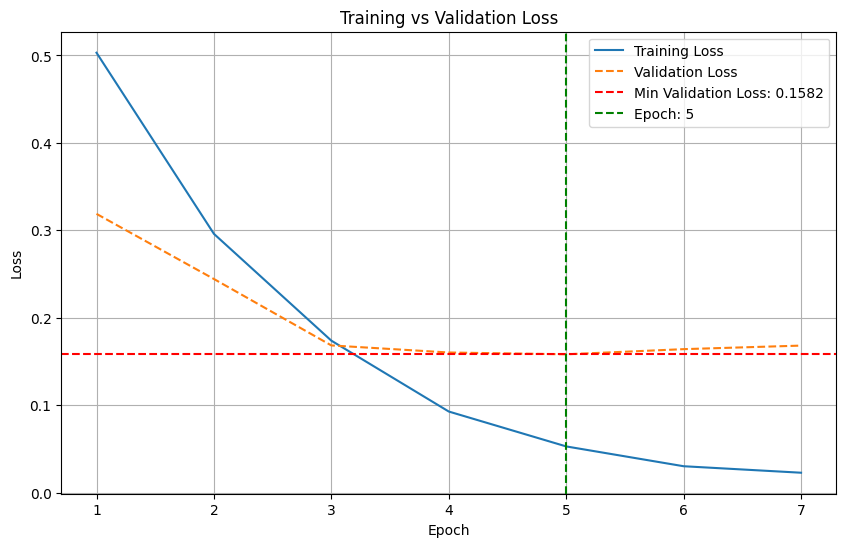

True labels [[('O', [0, 0]), ('B-Actor', [1, 1]), ('I-Actor', [2, 2]), ('B-Activity', [3, 4]), ('B-Actor', [5, 5]), ('I-Actor', [6, 7]), ('B-Activity Data', [8, 8]), ('I-Activity Data', [9, 14]), ('O', [15, 16])], [('O', [0, 0]), ('B-Actor', [1, 1]), ('I-Actor', [2, 3]), ('B-Activity', [4, 5]), ('B-Actor', [6, 6]), ('I-Actor', [7, 7]), ('O', [8, 8]), ('B-Activity Data', [9, 9]), ('I-Activity Data', [10, 10]), ('O', [11, 12])], [('O', [0, 0]), ('B-Actor', [1, 1]), ('I-Actor', [2, 2]), ('B-Activity', [3, 3]), ('B-Further Specification', [4, 4]), ('I-Further Specification', [5, 15]), ('O', [16, 17])], [('O', [0, 0]), ('B-Actor', [1, 1]), ('I-Actor', [2, 2]), ('B-Activity', [3, 5]), ('B-Activity Data', [6, 6]), ('I-Activity Data', [7, 11]), ('B-XOR Gateway', [12, 12]), ('B-Actor', [13, 13]), ('I-Actor', [14, 14]), ('B-Activity', [15, 17]), ('B-Activity Data', [18, 18]), ('I-Activity Data', [19, 23]), ('O', [24, 25])], [('O', [0, 0]), ('B-Actor', [1, 1]), ('I-Actor', [2, 3]), ('B-Activity',

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 3.0014, Precision: 0.8779, Recall: 0.7894, F1: 0.8259
Step 50, Loss: 0.3773, Precision: 0.8174, Recall: 0.9041, F1: 0.8586
Average training loss: 0.4942

True labels [[('O', [0, 0]), ('B-Actor', [1, 1]), ('I-Actor', [2, 3]), ('B-Activity', [4, 5]), ('B-Activity Data', [6, 6]), ('I-Activity Data', [7, 10]), ('O', [11, 11]), ('B-Actor', [12, 12]), ('I-Actor', [13, 14]), ('O', [15, 16])], [('O', [0, 0]), ('B-Actor', [1, 1]), ('I-Actor', [2, 3]), ('B-Activity', [4, 5]), ('B-Activity Data', [6, 6]), ('I-Activity Data', [7, 10]), ('O', [11, 12])], [('O', [0, 0]), ('B-Actor', [1, 1]), ('I-Actor', [2, 3]), ('B-Activity', [4, 5]), ('B-Activity Data', [6, 6]), ('I-Activity Data', [7, 10]), ('O', [11, 13]), ('B-XOR Gateway', [14, 14]), ('B-Actor', [15, 15]), ('I-Actor', [16, 17]), ('B-Activity', [18, 20]), ('B-Activity Data', [21, 21]), ('I-Activity Data', [22, 25]), ('O', [26, 31])], [('O', [0, 5]), ('B-Actor', [6, 6]), ('I-Actor', [7, 8]), ('B-Activity', [9, 

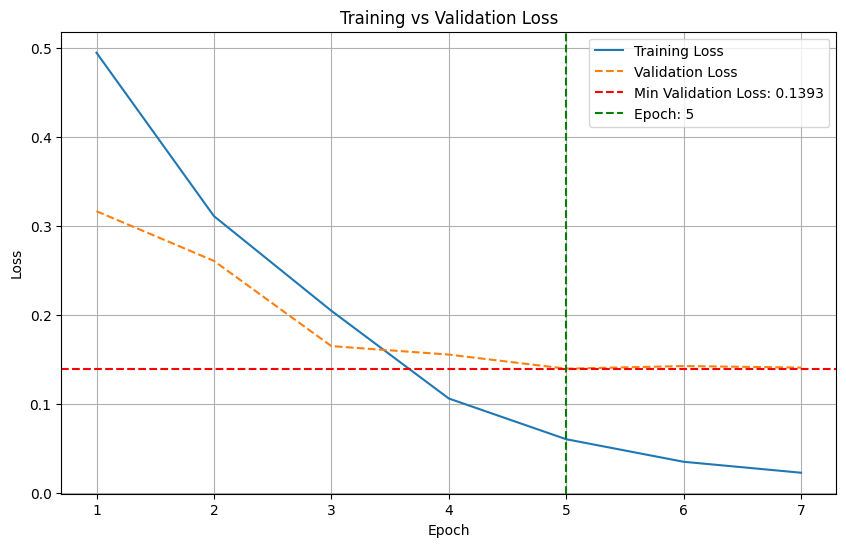

True labels [[('O', [0, 0]), ('B-Actor', [1, 1]), ('I-Actor', [2, 3]), ('B-Activity', [4, 5]), ('B-Activity Data', [6, 6]), ('I-Activity Data', [7, 10]), ('O', [11, 11]), ('B-Actor', [12, 12]), ('I-Actor', [13, 14]), ('O', [15, 16])], [('O', [0, 0]), ('B-Actor', [1, 1]), ('I-Actor', [2, 3]), ('B-Activity', [4, 5]), ('B-Activity Data', [6, 6]), ('I-Activity Data', [7, 10]), ('O', [11, 12])], [('O', [0, 0]), ('B-Actor', [1, 1]), ('I-Actor', [2, 3]), ('B-Activity', [4, 5]), ('B-Activity Data', [6, 6]), ('I-Activity Data', [7, 10]), ('O', [11, 13]), ('B-XOR Gateway', [14, 14]), ('B-Actor', [15, 15]), ('I-Actor', [16, 17]), ('B-Activity', [18, 20]), ('B-Activity Data', [21, 21]), ('I-Activity Data', [22, 25]), ('O', [26, 31])], [('O', [0, 5]), ('B-Actor', [6, 6]), ('I-Actor', [7, 8]), ('B-Activity', [9, 10]), ('B-Activity Data', [11, 11]), ('I-Activity Data', [12, 12]), ('B-Further Specification', [13, 13]), ('I-Further Specification', [14, 19]), ('O', [20, 21])], [('O', [0, 0]), ('B-Actor'

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.8568, Precision: 0.8896, Recall: 0.8299, F1: 0.8557
Step 50, Loss: 0.1194, Precision: 0.9090, Recall: 0.9342, F1: 0.9194
Average training loss: 0.4469

True labels [[('O', [0, 1]), ('B-Actor', [2, 2]), ('I-Actor', [3, 3]), ('B-Activity', [4, 4]), ('B-Activity Data', [5, 5]), ('I-Activity Data', [6, 10]), ('O', [11, 16]), ('B-Activity', [17, 17]), ('B-Activity Data', [18, 18]), ('I-Activity Data', [19, 20]), ('O', [21, 22])], [('O', [0, 13])], [('O', [0, 41])], [('O', [0, 33])], [('O', [0, 34])], [('O', [0, 0]), ('B-Actor', [1, 1]), ('B-Activity', [2, 3]), ('B-Activity Data', [4, 4]), ('I-Activity Data', [5, 22]), ('O', [23, 24])], [('O', [0, 12]), ('B-Actor', [13, 13]), ('O', [14, 15]), ('B-Activity', [16, 16]), ('B-Further Specification', [17, 17]), ('I-Further Specification', [18, 44]), ('O', [45, 46])], [('O', [0, 0]), ('B-AND Gateway', [1, 1]), ('O', [2, 6]), ('B-Activity', [7, 8]), ('B-Activity Data', [9, 10]), ('O', [11, 11]), ('B-Actor', [12

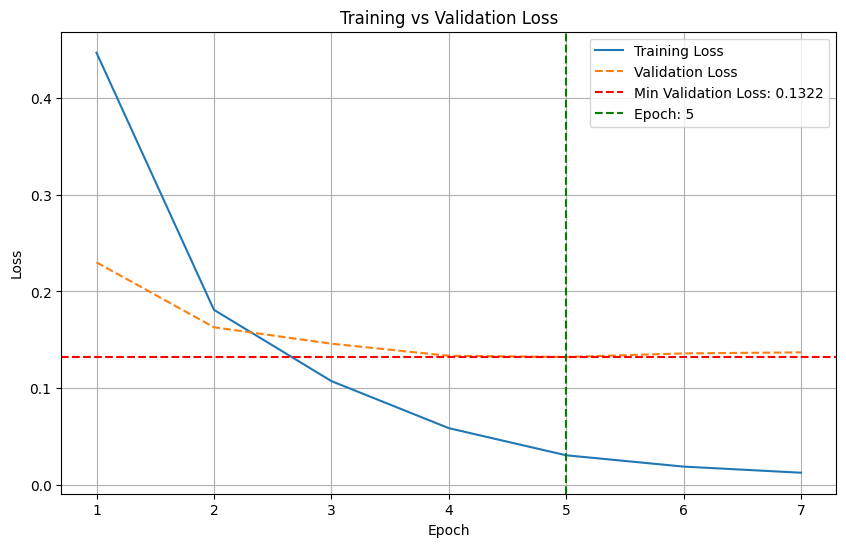

True labels [[('O', [0, 1]), ('B-Actor', [2, 2]), ('I-Actor', [3, 3]), ('B-Activity', [4, 4]), ('B-Activity Data', [5, 5]), ('I-Activity Data', [6, 10]), ('O', [11, 16]), ('B-Activity', [17, 17]), ('B-Activity Data', [18, 18]), ('I-Activity Data', [19, 20]), ('O', [21, 22])], [('O', [0, 13])], [('O', [0, 41])], [('O', [0, 33])], [('O', [0, 34])], [('O', [0, 0]), ('B-Actor', [1, 1]), ('B-Activity', [2, 3]), ('B-Activity Data', [4, 4]), ('I-Activity Data', [5, 22]), ('O', [23, 24])], [('O', [0, 12]), ('B-Actor', [13, 13]), ('O', [14, 15]), ('B-Activity', [16, 16]), ('B-Further Specification', [17, 17]), ('I-Further Specification', [18, 44]), ('O', [45, 46])], [('O', [0, 0]), ('B-AND Gateway', [1, 1]), ('O', [2, 6]), ('B-Activity', [7, 8]), ('B-Activity Data', [9, 10]), ('O', [11, 11]), ('B-Actor', [12, 13]), ('O', [14, 15]), ('B-Activity', [16, 17]), ('I-Activity', [18, 18]), ('B-Activity Data', [19, 19]), ('I-Activity Data', [20, 21]), ('O', [22, 23])], [('O', [0, 0]), ('B-Actor', [1, 1

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.7646, Precision: 0.8321, Recall: 0.8817, F1: 0.8501
Step 50, Loss: 0.3367, Precision: 0.9294, Recall: 0.9382, F1: 0.9322
Average training loss: 0.4258

True labels [[('O', [0, 8]), ('B-Activity', [9, 9]), ('O', [10, 10]), ('B-Actor', [11, 11]), ('I-Actor', [12, 14]), ('B-Activity Data', [15, 15]), ('I-Activity Data', [16, 18]), ('O', [19, 20])], [('O', [0, 0]), ('B-Activity Data', [1, 1]), ('I-Activity Data', [2, 2]), ('O', [3, 3]), ('B-Activity', [4, 5]), ('O', [6, 6]), ('B-Actor', [7, 9]), ('B-Activity', [10, 10]), ('O', [11, 11]), ('B-Activity Data', [12, 12]), ('I-Activity Data', [13, 15]), ('O', [16, 16]), ('B-Activity', [17, 17]), ('O', [18, 18]), ('B-Activity Data', [19, 19]), ('I-Activity Data', [20, 20]), ('O', [21, 21]), ('B-Activity', [22, 22]), ('O', [23, 24])], [('O', [0, 24])], [('O', [0, 1]), ('B-Activity Data', [2, 2]), ('I-Activity Data', [3, 3]), ('O', [4, 4]), ('B-Activity', [5, 6]), ('O', [7, 8]), ('B-Actor', [9, 9]), ('I-Actor'

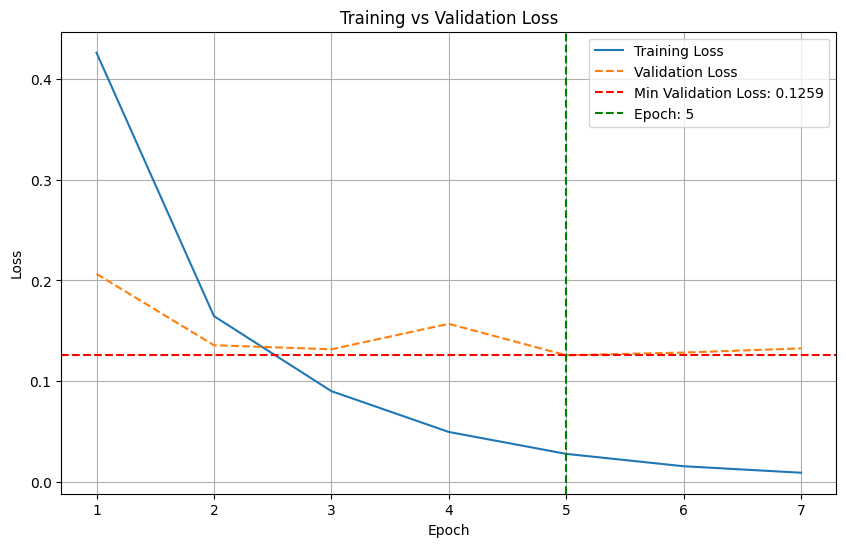

True labels [[('O', [0, 8]), ('B-Activity', [9, 9]), ('O', [10, 10]), ('B-Actor', [11, 11]), ('I-Actor', [12, 14]), ('B-Activity Data', [15, 15]), ('I-Activity Data', [16, 18]), ('O', [19, 20])], [('O', [0, 0]), ('B-Activity Data', [1, 1]), ('I-Activity Data', [2, 2]), ('O', [3, 3]), ('B-Activity', [4, 5]), ('O', [6, 6]), ('B-Actor', [7, 9]), ('B-Activity', [10, 10]), ('O', [11, 11]), ('B-Activity Data', [12, 12]), ('I-Activity Data', [13, 15]), ('O', [16, 16]), ('B-Activity', [17, 17]), ('O', [18, 18]), ('B-Activity Data', [19, 19]), ('I-Activity Data', [20, 20]), ('O', [21, 21]), ('B-Activity', [22, 22]), ('O', [23, 24])], [('O', [0, 24])], [('O', [0, 1]), ('B-Activity Data', [2, 2]), ('I-Activity Data', [3, 3]), ('O', [4, 4]), ('B-Activity', [5, 6]), ('O', [7, 8]), ('B-Actor', [9, 9]), ('I-Actor', [10, 13]), ('O', [14, 15]), ('B-Actor', [16, 16]), ('I-Actor', [17, 19]), ('B-Activity', [20, 21]), ('B-Activity Data', [22, 22]), ('I-Activity Data', [23, 25]), ('O', [26, 26]), ('B-Activ

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.8777, Precision: 0.8562, Recall: 0.6894, F1: 0.7595
Step 50, Loss: 0.3368, Precision: 0.7966, Recall: 0.8867, F1: 0.8342
Average training loss: 0.5103

True labels [[('O', [0, 0]), ('B-Actor', [1, 1]), ('I-Actor', [2, 3]), ('B-Activity', [4, 5]), ('I-Activity', [6, 6]), ('O', [7, 11]), ('B-Actor', [12, 12]), ('I-Actor', [13, 14]), ('B-Activity', [15, 15]), ('B-Activity Data', [16, 16]), ('I-Activity Data', [17, 18]), ('O', [19, 19]), ('B-Activity', [20, 20]), ('I-Activity', [21, 21]), ('B-Activity Data', [22, 22]), ('I-Activity Data', [23, 26]), ('O', [27, 29])], [('O', [0, 0]), ('B-XOR Gateway', [1, 1]), ('B-Condition Specification', [2, 2]), ('I-Condition Specification', [3, 12]), ('O', [13, 18]), ('B-XOR Gateway', [19, 20]), ('B-Actor', [21, 21]), ('B-Activity', [22, 23]), ('B-Activity Data', [24, 24]), ('I-Activity Data', [25, 25]), ('B-Further Specification', [26, 26]), ('I-Further Specification', [27, 29]), ('O', [30, 31])], [('O', [0, 24])],

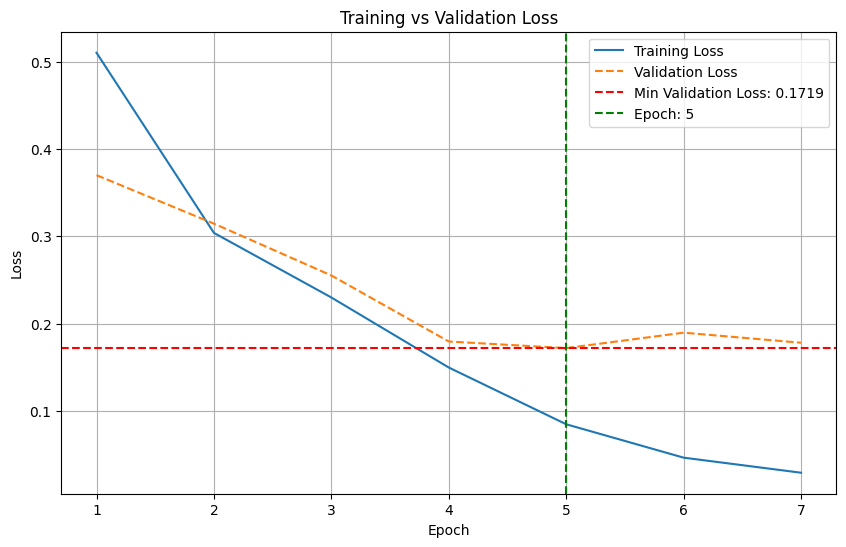

True labels [[('O', [0, 0]), ('B-Actor', [1, 1]), ('I-Actor', [2, 3]), ('B-Activity', [4, 5]), ('I-Activity', [6, 6]), ('O', [7, 11]), ('B-Actor', [12, 12]), ('I-Actor', [13, 14]), ('B-Activity', [15, 15]), ('B-Activity Data', [16, 16]), ('I-Activity Data', [17, 18]), ('O', [19, 19]), ('B-Activity', [20, 20]), ('I-Activity', [21, 21]), ('B-Activity Data', [22, 22]), ('I-Activity Data', [23, 26]), ('O', [27, 29])], [('O', [0, 0]), ('B-XOR Gateway', [1, 1]), ('B-Condition Specification', [2, 2]), ('I-Condition Specification', [3, 12]), ('O', [13, 18]), ('B-XOR Gateway', [19, 20]), ('B-Actor', [21, 21]), ('B-Activity', [22, 23]), ('B-Activity Data', [24, 24]), ('I-Activity Data', [25, 25]), ('B-Further Specification', [26, 26]), ('I-Further Specification', [27, 29]), ('O', [30, 31])], [('O', [0, 24])], [('O', [0, 5]), ('B-Activity', [6, 6]), ('O', [7, 7]), ('B-Activity', [8, 8]), ('B-Activity Data', [9, 9]), ('I-Activity Data', [10, 11]), ('O', [12, 12]), ('B-AND Gateway', [13, 14]), ('O'

In [ ]:
epoch_best = 7 #DONE
learning_rate = 5e-05
best_model, avg_macro_f1, avg_micro_f1, avg_weigthed_f1, label_f1 = grouped_k_fold_cross_validation(input_data, 5, BATCH_SIZE, epoch_best, label_map, learning_rate)


#3. Model Saving for Pipeline

First we need to create a subset of the data to keep separate documents for testing. These documents are then also removed from the original training data before it goes through training.

##3.1.1 Remove 6 documents for testing


In [ ]:
#@title Training Model
def train_model_pipeline(input_data_pipeline, BATCH_SIZE, EPOCHS, label_map, learning_rate):
  # Training of the model
  # Instantiate the dataset and dataloader for validation
  train_data, val_data = train_test_split(input_data_pipeline, test_size=0.2, random_state=SEED)

  train_dataset = NERDataset(
      sentences=[entry['tokens'] for entry in train_data],
      labels=[entry['ner-tags'] for entry in train_data],
      tokenizer=tokenizer,
      max_len=MAX_LEN,
      label_map=label_map
  )
  # Instantiate the dataset and dataloader for validation
  val_dataset = NERDataset(
      sentences=[entry['tokens'] for entry in val_data],
      labels=[entry['ner-tags'] for entry in val_data],
      tokenizer=tokenizer,
      max_len=MAX_LEN,
      label_map=label_map
  )

  #Initialize the DataLoader objects
  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


  #loading the desired model: each fold we need start fresh
  model = RobertaForTokenClassification.from_pretrained("roberta-base", num_labels=NUM_LABELS)

  # Fine-tuning setup, can be changed for model optimisation
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
  total_steps = len(train_loader) * EPOCHS
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

  # Using funtion defined above to train the model and obtain the losses for plotting at the same time
  model, training_losses, validation_losses = train_model(model, train_loader, val_loader, optimizer, scheduler, EPOCHS, label_map)
  plot_losses(training_losses,validation_losses)

  #Evaluating the model in this fold
  val_metrics = evaluate_model(model, val_loader, label_map)

  #So it is printed pretty :)
  header = "{:<35} {:<10} {:<10} {:<10}\n".format("Label", "Precision", "Recall", "F1")
  row_format = "{:<35} {:<10} {:<10} {:<10}\n"
  print(header)
  for label, metrics in val_metrics['detailed_metrics'].items():
    print(row_format.format(label, "{:.4f}".format(metrics['precision']), "{:.4f}".format(metrics['recall']), "{:.4f}".format(metrics['f1'])))

  # Now, label_f1_scores[label] holds a list of F1 scores for that label across all folds
  return model

Based on the testing on proper learning rates and looking at the loss graphs we set the epochs to 5 and the lr to ```5e-05```.

{'doc-10.12', 'doc-9.3', 'doc-10.7', 'doc-8.2', 'doc-3.1', 'doc-20.5 - edit pictures'}
data loaded


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.6421, Precision: 0.7962, Recall: 0.8792, F1: 0.8356
Step 47, Loss: 0.2221, Precision: 0.8187, Recall: 0.8971, F1: 0.8543
Average training loss: 0.5041

True labels [[('O', [0, 1]), ('B-Actor', [2, 2]), ('I-Actor', [3, 4]), ('B-Activity', [5, 5]), ('B-Activity Data', [6, 6]), ('I-Activity Data', [7, 8]), ('O', [9, 11]), ('B-Actor', [12, 12]), ('I-Actor', [13, 14]), ('B-Activity', [15, 15]), ('B-Activity Data', [16, 16]), ('I-Activity Data', [17, 18]), ('B-Further Specification', [19, 19]), ('I-Further Specification', [20, 21]), ('O', [22, 23])], [('O', [0, 2]), ('B-Actor', [3, 3]), ('B-Activity', [4, 4]), ('B-Activity Data', [5, 5]), ('I-Activity Data', [6, 14]), ('O', [15, 16]), ('B-Activity', [17, 17]), ('B-Activity Data', [18, 18]), ('O', [19, 19]), ('B-Actor', [20, 20]), ('I-Actor', [21, 21]), ('O', [22, 38])], [('O', [0, 0]), ('B-Actor', [1, 1]), ('I-Actor', [2, 6]), ('B-Activity', [7, 8]), ('B-Activity Data', [9, 9]), ('I-Activity Data', [10, 

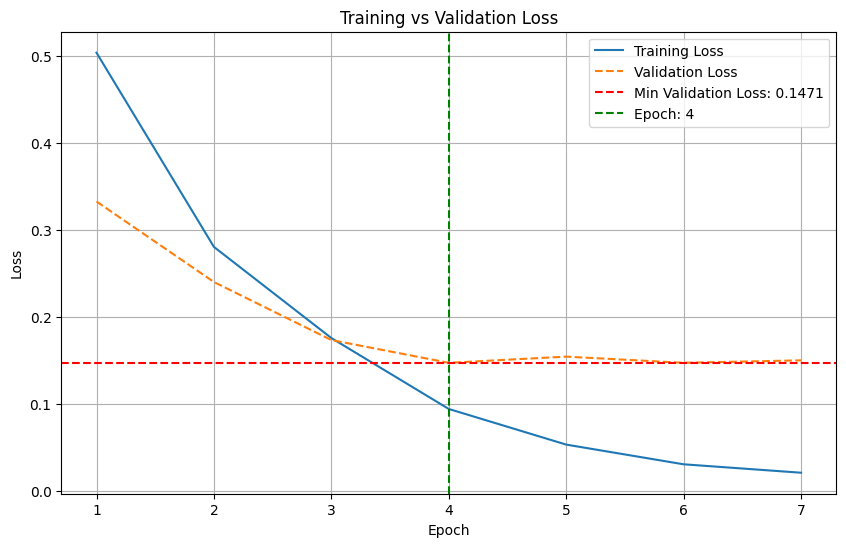

True labels [[('O', [0, 1]), ('B-Actor', [2, 2]), ('I-Actor', [3, 4]), ('B-Activity', [5, 5]), ('B-Activity Data', [6, 6]), ('I-Activity Data', [7, 8]), ('O', [9, 11]), ('B-Actor', [12, 12]), ('I-Actor', [13, 14]), ('B-Activity', [15, 15]), ('B-Activity Data', [16, 16]), ('I-Activity Data', [17, 18]), ('B-Further Specification', [19, 19]), ('I-Further Specification', [20, 21]), ('O', [22, 23])], [('O', [0, 2]), ('B-Actor', [3, 3]), ('B-Activity', [4, 4]), ('B-Activity Data', [5, 5]), ('I-Activity Data', [6, 14]), ('O', [15, 16]), ('B-Activity', [17, 17]), ('B-Activity Data', [18, 18]), ('O', [19, 19]), ('B-Actor', [20, 20]), ('I-Actor', [21, 21]), ('O', [22, 38])], [('O', [0, 0]), ('B-Actor', [1, 1]), ('I-Actor', [2, 6]), ('B-Activity', [7, 8]), ('B-Activity Data', [9, 9]), ('I-Activity Data', [10, 15]), ('O', [16, 16]), ('B-Actor', [17, 17]), ('I-Actor', [18, 24]), ('O', [25, 25]), ('B-XOR Gateway', [26, 26]), ('B-Actor', [27, 27]), ('I-Actor', [28, 32]), ('B-Activity', [33, 35]), ('B

In [ ]:
def pick_and_remove_documents(data, num_docs, SEED):
    # Pick 6 documents at random
    random.seed(SEED)
    selected_docs_indices = random.sample(range(len(data)), num_docs)
    selected_docs = [data[i] for i in selected_docs_indices]

    # Remove the selected documents from the original data
    remaining_docs = [doc for i, doc in enumerate(data) if i not in selected_docs_indices]

    return selected_docs, remaining_docs

try:

  selected_docs, remaining_docs = pick_and_remove_documents(unflattened_data, 6, SEED)
  folder_path = '/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/TESTING DATA/NER_TESTING/'

  check= set()
  for document in selected_docs:
    for sentence in document:
      check.add(sentence['document name'])
  print(check)

  # here the selected documents are saved for pipeline testing
  for i, document in enumerate(selected_docs):
        file_path = os.path.join(folder_path, f'document_{i+1}.json')
        with open(file_path, 'w') as file:
            for sentence in document:
                # Convert the sentence to a JSON string and write it with a newline
                json_line = json.dumps(sentence) + '\n'
                file.write(json_line)

  input_data_pipeline = [item for group in remaining_docs for item in group]

  if input_data_pipeline:
    print('data loaded')

  #training of the model without the 6 left out documents
  epochs_pipe= 7 #DONE
  lr= 5e-05
  model2 = train_model_pipeline(input_data_pipeline, BATCH_SIZE, epochs_pipe, label_map, lr)

except FileNotFoundError as fnf:
  print("File was not found or incorrect file directory, please try to run cell again")

##3.1.2 Training BERT on full data

##3.2 Training and saving the model



In [ ]:
# Save the model to a file
# Assuming 'best_model' is your trained model and 'tokenizer' is your tokenizer
model_path = "/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/NER MODELS/RoBERTa_base/6DOCLEFTOUT/MODEL/"
tokenizer_path = "/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/NER MODELS/RoBERTa_base/6DOCLEFTOUT/TOKENIZER/"

# Save the model & tokenizer
model2.save_pretrained(model_path)
tokenizer.save_pretrained(tokenizer_path)

('/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/NER MODELS/RoBERTa_base/6DOCLEFTOUT/TOKENIZER/tokenizer_config.json',
 '/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/NER MODELS/RoBERTa_base/6DOCLEFTOUT/TOKENIZER/special_tokens_map.json',
 '/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/NER MODELS/RoBERTa_base/6DOCLEFTOUT/TOKENIZER/vocab.json',
 '/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/NER MODELS/RoBERTa_base/6DOCLEFTOUT/TOKENIZER/merges.txt',
 '/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/NER MODELS/RoBERTa_base/6DOCLEFTOUT/TOKENIZER/added_tokens.json')